# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

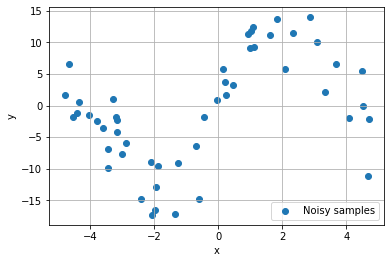

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

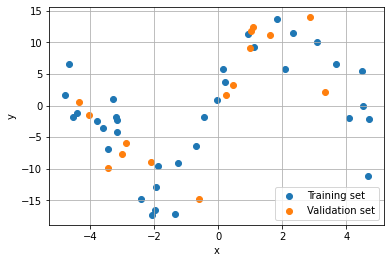

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

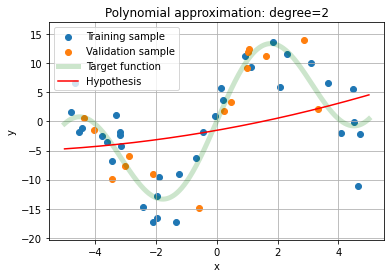

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

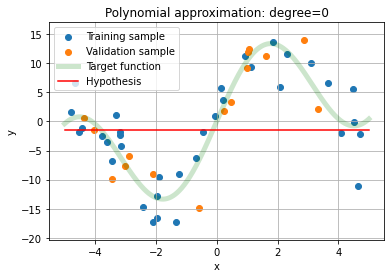

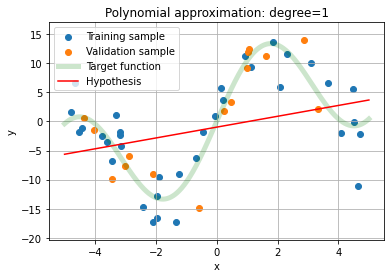

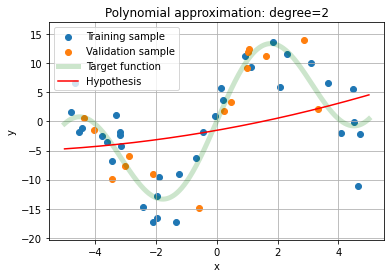

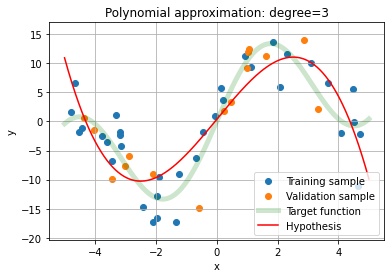

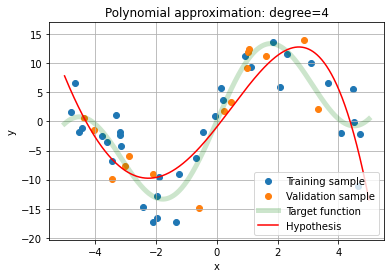

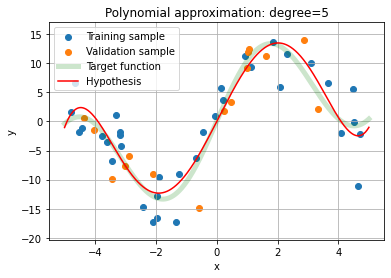

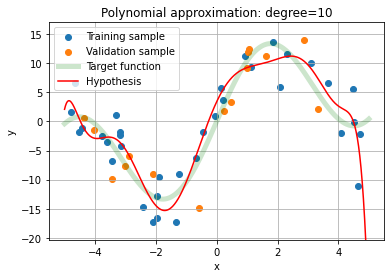

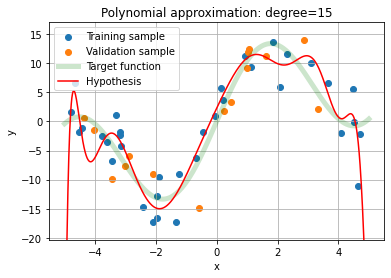

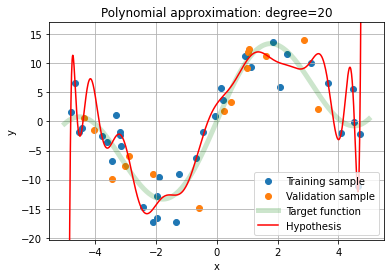

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

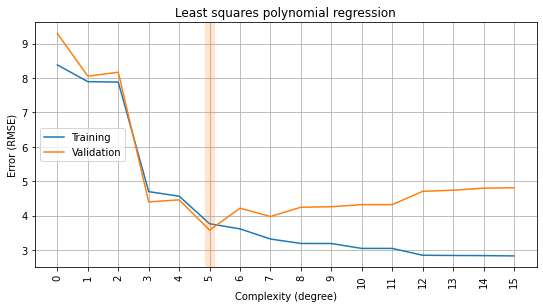

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

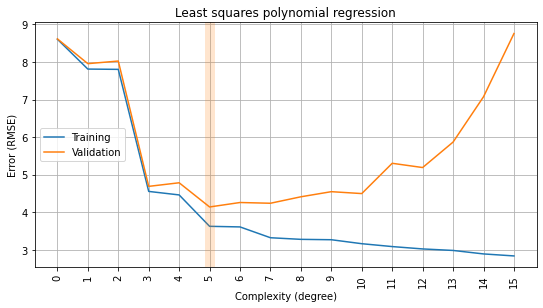

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

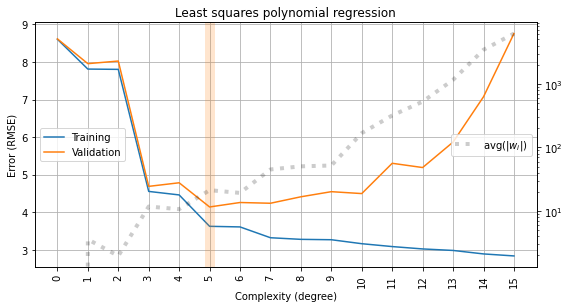

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

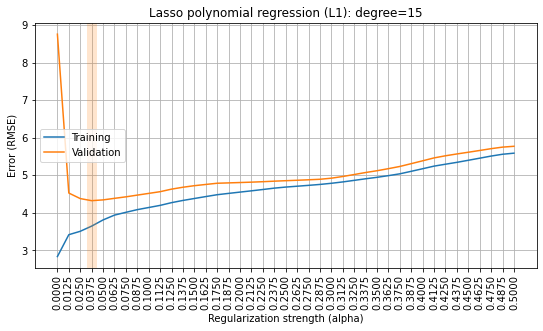

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

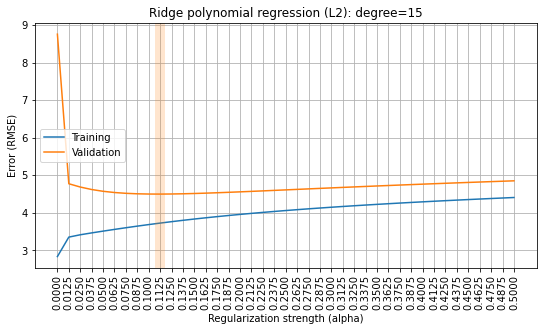

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

# Замечание
Пробовал брать часть признаков для генерации полиномов, а потом обучать на всех данных, но для 15 степеней у меня считало более 20 минут и никакого результата не выдало. Поэтому далее я буду везде брать до 12 степени. Полиномизировал на одном признаке, а обучал на всех(как и сказано в инструкции)

**UPD:
Получиолсь построить по 15 признакам) Ниже вариант и для 1 признаков и для 12**

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
#print(data['DESCR']);

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
# your findings/conclusions
#X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes.iloc[:, :2], y_diabetes, test_size=0.3, random_state=SEED)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_diabetes.iloc[:, 2:10], y_diabetes, test_size=0.3, random_state=SEED)                                 

In [23]:
full_train = pd.concat([X_train,X_train_2], axis=1)
full_valid = pd.concat([X_valid,X_valid_2], axis=1)

In [59]:
X_full = X_diabetes.iloc[:, :1]

In [24]:
full_train.shape

(309, 10)

In [40]:
def make_model_3(alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model_3())


Pipeline(steps=[('sca', StandardScaler()), ('reg', LinearRegression())])

In [41]:
DEGREES = [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]


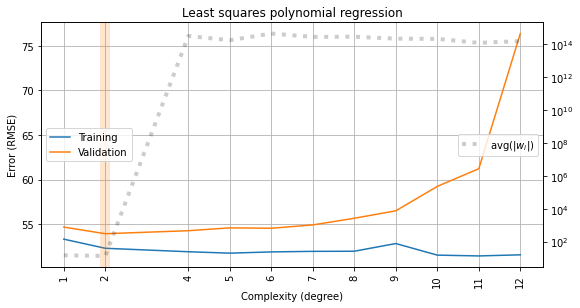

Wall time: 858 ms


In [58]:
%%time
rmse_train, rmse_valid,coef_l1_LR = [], [], []
alo = []
for degree in DEGREES:
    alo = PolynomialFeatures(degree=degree).fit_transform(X_diabetes.iloc[:, :2].values)
    full_train_2 = np.concatenate([alo,X_diabetes.iloc[:, 2:10].values], axis=1)
    results = cross_validate(make_model_3(), 
                             full_train_2, y_diabetes, cv=5,
                             return_train_score=True,return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    coef_l1_LR.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    

plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=coef_l1_LR, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

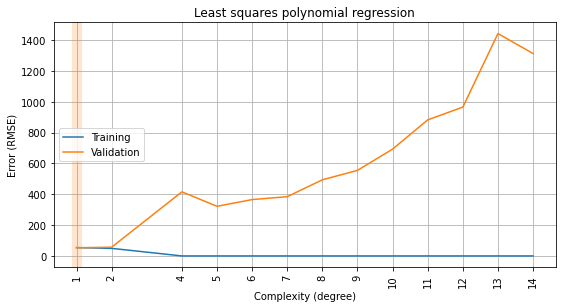

Wall time: 4min 2s


In [61]:
%%time

DEGREES =  [1,  2,  4,  5,  6,  7,  8,9, 10, 11,12,13,14]
rmse_train, rmse_valid = [], []
PolynomialFeatures(degree=12).fit_transform(X_full.values)
for degree in DEGREES:
    reg = make_model(degree).fit(full_train, y_train)
    rmse_train.append(rmse(reg.predict(full_train), y_train))
    rmse_valid.append(rmse(reg.predict(full_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')


In [29]:
DEGREES[np.argmin(rmse_valid)]

1

**на степенях 1 и 2 мы видим малую ошибку на train и test. С 2-ой степени заметно сильное расхождение. Это может происходить из-за переобучения. Но в нашем случае не совсем ясно недообучена или обучена нормально наша модель на 1 и 2 степени. В примере это было явно видно.
По расчетам лучший случай для нас - 1 степень**

## Degree of 3 causes overfiting

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.


**Я выбрал степень 4, где у меня происходит переобучение.** На 15 очень долго считает.

#### L1

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1493.7184642470274, tolerance: 215.31875694050996
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2970.985429845112, tolerance: 204.37875694050993
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2065.2611123468887, tolerance: 207.00184971751415
  model = cd_fast.enet_coordinate_descent(

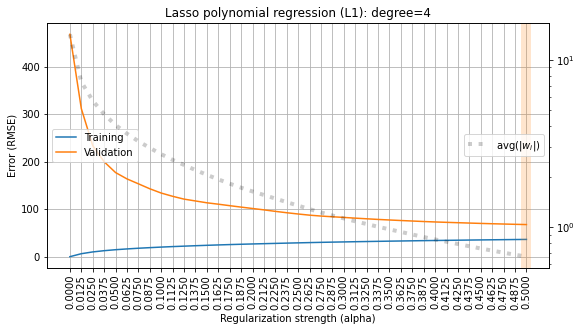

In [121]:
## your code
rmse_train, rmse_valid,coef_l1_LR = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=4, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    coef_l1_LR.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=coef_l2_LR, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=4')

In [102]:
# you can verify the reduction of coefficients by viewing the maximum value for the coefficient with lasso regression, with ridge regressions and without both
coef_reg = make_model(degree=2).fit(X_train, y_train)['reg'].coef_
coef_lasso = make_model(degree=2, penalty='L2',alpha=0.5).fit(X_train, y_train)['reg'].coef_
coef_ridge = make_model(degree=2, penalty='L1',alpha=0.5).fit(X_train, y_train)['reg'].coef_

print(coef_reg.max())
print(coef_lasso.max())
print(coef_ridge.max())


4968.50389031767
35.616693407519215
22.30303344574478


#### L2

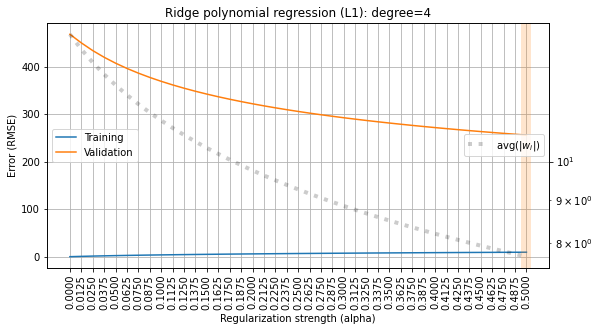

In [112]:
## your code
rmse_train, rmse_valid,coef_l2_LR = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=4, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    coef_l2_LR.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(model['reg'].coef_)
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=coef_l2_LR, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=4')

#### Summary

**What does a large coefficient signify? It means that we’re putting a lot of emphasis on that feature, i.e. the particular feature is a good predictor for the outcome. When it becomes too large, the algorithm starts modelling intricate relations to estimate the output and ends up overfitting to the particular training data**

**it can be noticed that as the alpha coefficient increases, the average value of the coefficients tends to zero. Hence we conclude that with the coefficient alpha = infinity, our coefficients will be zero. That is, we simplify the model by this**

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [103]:
sparsity_l1_LR_list,sparsity_l2_LR_list = [],[]
for alpha in ALPHAS:
    coef_l1_LR = make_model(degree=15, penalty='L1',alpha=alpha).fit(X_train, y_train)['reg'].coef_.ravel()
    sparsity_l1_LR_list.append(np.mean(coef_l1_LR == 0) * 100)
    coef_l2_LR = make_model(degree=15, penalty='L2',alpha=alpha).fit(X_train, y_train)['reg'].coef_.ravel()
    sparsity_l2_LR_list.append(np.mean(coef_l2_LR == 0) * 100)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16782.44830729277, tolerance: 189.98190873786407
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 823.7091384627856, tolerance: 189.98190873786407
  model = cd_fast.enet_coordinate_descent(


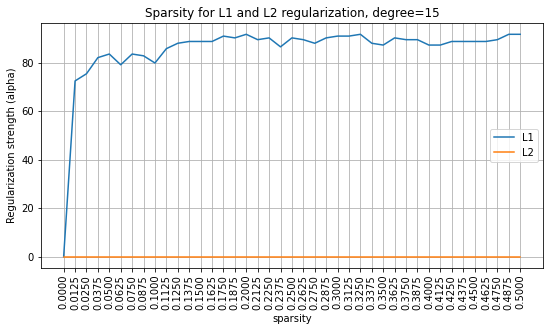

In [104]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, sparsity_l1_LR_list, label='L1')
plt.plot(ALPHAS, sparsity_l2_LR_list, color='C1', label='L2')
plt.title('Sparsity for L1 and L2 regularization, degree=15')
plt.xlabel('sparsity')
plt.ylabel('Regularization strength (alpha)')
plt.grid(True)
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='center right') 

#### Summary



**The graph shows that the blue line - 'sparsity for L1' immediately reaches large values. This suggests that a lot of values will set to zero and our system is greatly simplified.
However, the L2 line remains constant(0), which means that there is no zeroing of objects.**

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [107]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [111]:
X_hw.shape, y_hw.shape

((50, 3), (50,))

попробуем сделать без standart scaler

In [112]:
X_train_3, X_valid_3, y_train_3, y_valid_3 = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

In [121]:
#новая функция без шага с StandartScaler
def make_model_2(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('reg', regressor)
    ])

display(make_model_2(2))
display(make_model_2(2, penalty='L1', alpha=0.1))
display(make_model_2(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

Ниже я для L1 и L2 построю графики с standartscaler и без. 

#### L1




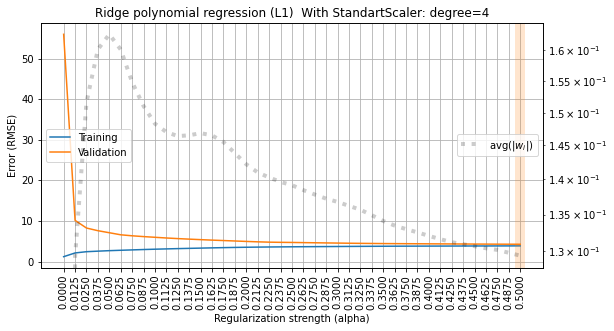

In [146]:
rmse_train, rmse_valid,coef_l1_LR = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=4, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    coef_l1_LR.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(model['reg'].coef_)
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=coef_l1_LR, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L1)  With StandartScaler: degree=4')

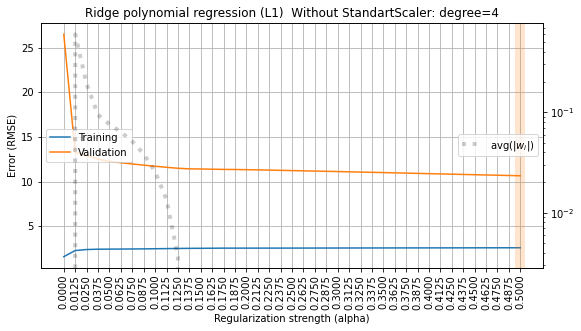

In [147]:
rmse_train, rmse_valid,coef_l1_LR = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_2(degree=4, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    coef_l1_LR.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(model['reg'].coef_)
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=coef_l1_LR, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L1)  Without StandartScaler: degree=4')

#### L2

In [143]:
import warnings
warnings.filterwarnings('ignore')

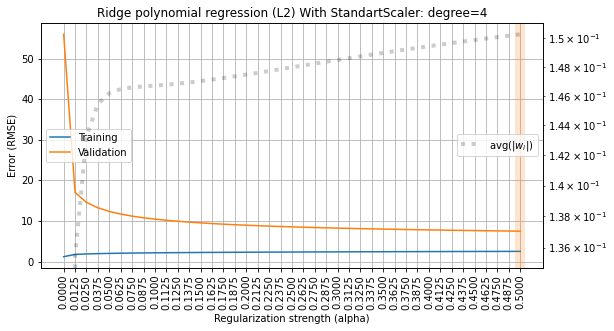

In [151]:
rmse_train, rmse_valid,coef_l2_LR = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=4, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    coef_l2_LR.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(model['reg'].coef_)
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=coef_l2_LR, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2) With StandartScaler: degree=4')

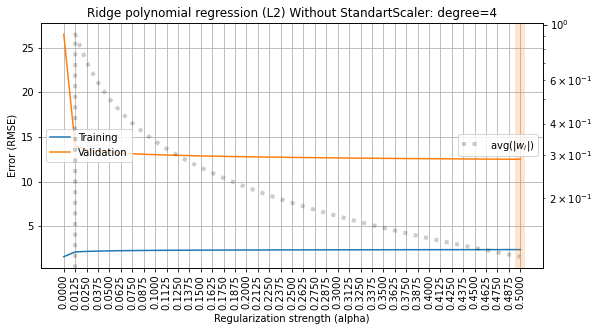

In [152]:
rmse_train, rmse_valid,coef_l2_LR = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_2(degree=4, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    coef_l2_LR.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(model['reg'].coef_)
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=coef_l2_LR, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2) Without StandartScaler: degree=4')

#### Summary



## your observations/conclusions
without regularization you'll get an equivalent solution whether you apply some kind of linear scaling or not. That's precisely why we can do feature scaling. The exception, of course, is when you apply regularization. Then linear scaling can change the results dramatically.


Lasso regression puts constraints on the size of the coefficients associated to each variable. However, this value will depend on the magnitude of each variable. It is therefore necessary to center and reduce, or standardize, the variables.

So, scaling also decreases the need for a big values of coefficients. Thus, the optimal value of lambda would be usually smaller, which corresponds to a smaller sum of squared values of coefficients


## Scaling is important if regularization is used